In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def exact_solution(d, w0, t):
    assert d<w0
    w =np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u
class FCN(nn.Module):
    # Defines a standad fully- connected network in pytorch
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.sin
        self.fcs = nn.Sequential(*[
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()])
        self.fch = nn.Sequential(*[
            nn.Sequential(*[
            nn.Linear( N_HIDDEN, N_HIDDEN),
            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        u = self.fce(x)
        return x
    

In [2]:
def exact_solution(d, w0, t):
    assert d<w0
    w =np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        self.fcs = nn.Linear(N_INPUT, N_HIDDEN)  # First layer
        self.fch = nn.ModuleList([
            nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS-1)  # Hidden layers
        ])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)  # Output layer

    def forward(self, x):
        x = torch.sin(self.fcs(x))  # Apply sin activation
        for layer in self.fch:
            x = torch.sin(layer(x))  # Apply sin activation for hidden layers
        u = self.fce(x)  # Final output layer (linear)
        return u


In [3]:
torch.manual_seed (123)
# define a neural network to train
# TODO: write code here
pinn = FCN(1,1,32,3)
# define boundary points, for the boundary loss
# TODO: write code here
# t_boundry = torch.tensor(0.).view(-1,1).requires_grad(True)
t_boundary = torch.tensor([[0.0]], requires_grad=True).view(-1,1)
# define training points over the entire domain, for the physics loss
# TODO: write code here
# t_physics = torch.linspace(0,1,30).view(-1, 1).requires_grad(True)
t_physics = torch.linspace(0, 1, 30, requires_grad=True).view(-1, 1)  #
# train the PINN
d, w0= 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace (0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.LBFGS(pinn.parameters(), lr=1e-2, max_iter=20)
for i in range (130001):
    optimiser.zero_grad()
    #compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-2
    # compute boundary loss
    # TODO: write code here
    u = pinn(t_boundary)# (1,1)
    loss1 = (torch.squeeze(u)-1)**2
    # print(f"U is {u} and u ends")
    # print(t_boundary)
    # dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True, allow_unused=True)[0]
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True, allow_unused=True)[0]

    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute Physics loss
    # TODO : write code here
    
    u = pinn(t_physics)
    # dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True, allow_unused=True )[0]
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True, allow_unused=True,  retain_graph=True)[0]
    # dudt_sum = dudt.sum()
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True, allow_unused=True ,  retain_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    
    # Backpropogation joiunt loss, take optimiser step
    #  TODO: write code here
    loss = (loss1 + lambda1*loss2 + lambda2*loss3).sum()
    
    print(f"Loss value : {loss}")
    loss.backward()
    optimiser.step()
    
    # plot tehg result as training progress
if i % 10 == 0:
    #print()
    u = pinn(t_test).detach()
    plt.figure(figsize = (6,2))
    plt.scatter(t_physics.detach()[:,0],
                torch.zeros_like(t_physics)[:,0], s= 20, lw=0, color="tab:blue", alpha = 0.6 )
    plt.scatter(t_boundary.detach()[:,0],
                torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha = 0.6 )
    plt.plot(t_test[:,0], u_exact[:,0], label = "Exact Solution", color="tab:grey", alpha = 0.6)
    plt.plot(t_test[:,0], u[:,0], label = "PINN solution", color = "tab:green")
    plt.title(f"Training step{i}")
    plt.legend()
    plt.show()
    
    
    
    

Loss value : 11.679498672485352


TypeError: LBFGS.step() missing 1 required positional argument: 'closure'

In [ ]:
optimiser = torch.optim.LBFGS(pinn.parameters(), lr=1e-2, max_iter=20)

def closure():
    optimiser.zero_grad()
    
    # Compute each term of the PINN loss function
    lambda1, lambda2 = 1e-1, 1e-2  # Adjusted lambda2 to give physics loss more weight

    # Boundary loss
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1) ** 2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0) ** 2

    # Physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True, retain_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)

    # Total loss
    loss = (loss1 + lambda1 * loss2 + lambda2 * loss3).sum()
    
    loss.backward()  # Compute gradients
    return loss

for i in range(130001):
    loss = optimiser.step(closure)  # Use closure function
    
    if i % 10 == 0:
        print(f"Step {i}: Loss = {loss.item()}")

        # Plot results during training
        u = pinn(t_test).detach()
        plt.figure(figsize=(6, 2))
        plt.scatter(t_physics.detach()[:, 0], torch.zeros_like(t_physics)[:, 0], s=20, lw=0, color="tab:blue", alpha=0.6)
        plt.scatter(t_boundary.detach()[:, 0], torch.zeros_like(t_boundary)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], u_exact[:, 0], label="Exact Solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

Step 0: Loss = 40.10936737060547


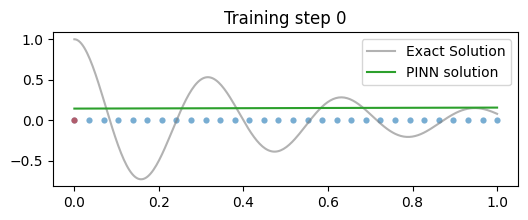

Step 100: Loss = 0.9944069981575012


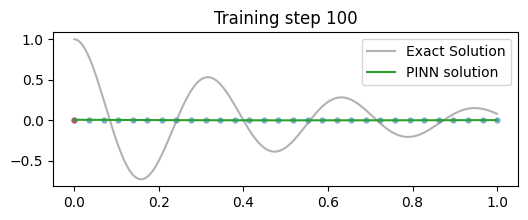

Step 200: Loss = 0.991532027721405


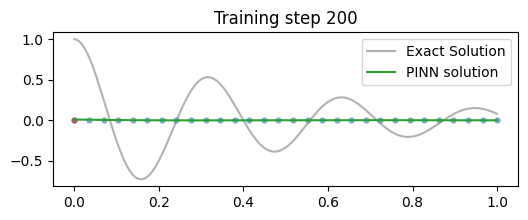

Step 300: Loss = 0.9872910380363464


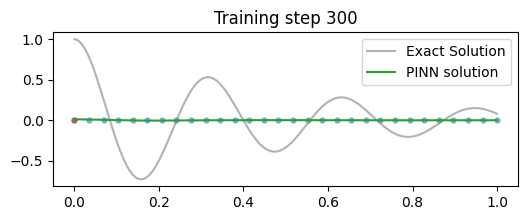

Step 400: Loss = 0.9123342633247375


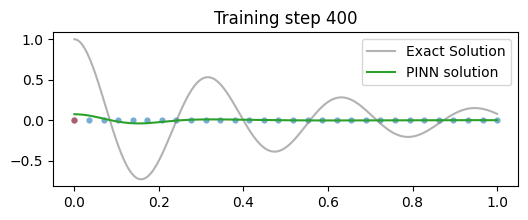

Step 500: Loss = 0.7412026524543762


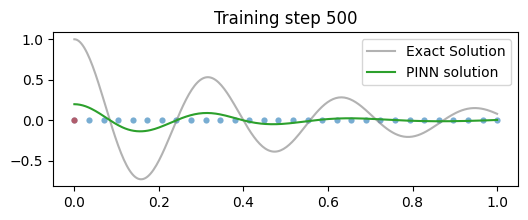

Step 600: Loss = 0.19906222820281982


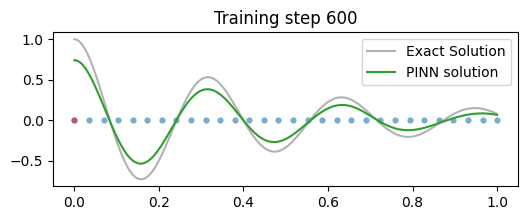

Step 700: Loss = 0.016633760184049606


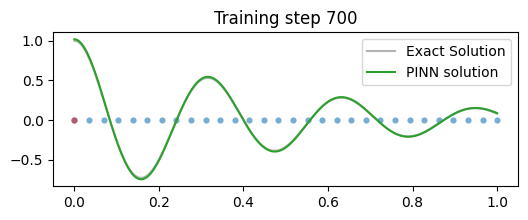

Step 800: Loss = 0.009720439091324806


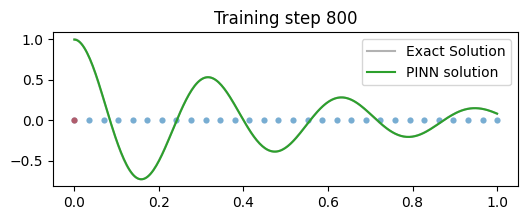

Step 900: Loss = 0.006577636115252972


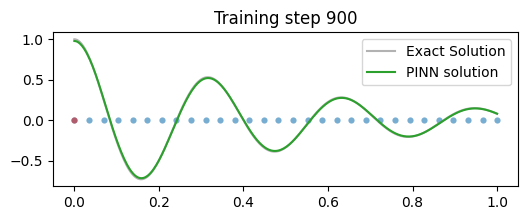

Step 1000: Loss = 0.006407767068594694


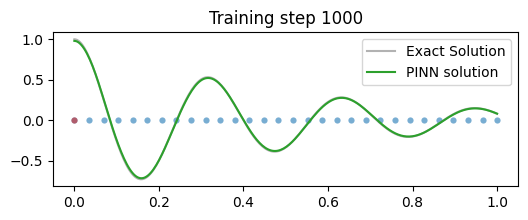

Step 1100: Loss = 0.0068857972510159016


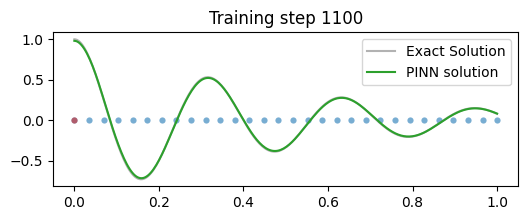

Step 1200: Loss = 0.0077637541107833385


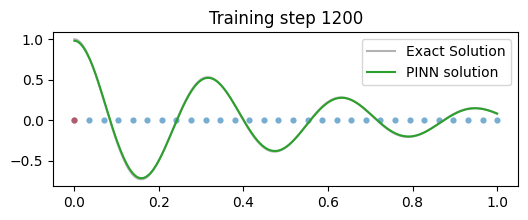

Step 1300: Loss = 0.009242088533937931


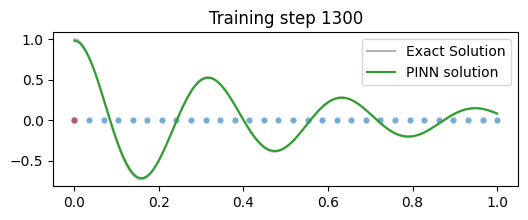

Step 1400: Loss = 0.006412608083337545


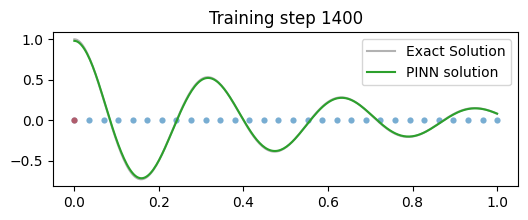

Step 1500: Loss = 0.006341675296425819


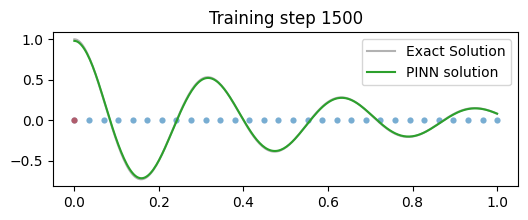

Step 1600: Loss = 0.00632369052618742


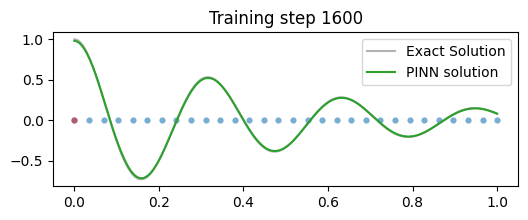

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(123)

# Define exact solution function
def exact_solution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(phi + w * t)
    exp = torch.exp(-d * t)
    u = exp * 2 * A * cos
    return u

# Define Fully Connected Neural Network (FCN)
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        self.fcs = nn.Linear(N_INPUT, N_HIDDEN)  # First layer
        self.fch = nn.ModuleList([nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)  # Output layer

    def forward(self, x):
        x = torch.tanh(self.fcs(x))  # Tanh activation for smooth learning
        for layer in self.fch:
            x = torch.tanh(layer(x))
        u = self.fce(x)  # Output layer (linear activation)
        return u

# Initialize PINN model
pinn = FCN(1, 1, 64, 5)

# Define boundary and training points
t_boundary = torch.tensor([[0.0]], requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 1, 30, requires_grad=True).view(-1, 1)

# Define parameters for harmonic motion
d, w0 = 2, 20
mu, k = 2 * d, w0**2

# Test set for evaluation
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

# Define optimizer
optimiser = torch.optim.LBFGS(pinn.parameters(), lr=1e-3, max_iter=20)

# Define closure function for LBFGS
def closure():
    optimiser.zero_grad()
    
    # Hyperparameters for loss scaling
    lambda1, lambda2 = 1e-1, 1e-2  

    # Compute boundary loss
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1) ** 2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0) ** 2

    # Compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True, retain_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)

    # Total loss
    loss = (loss1 + lambda1 * loss2 + lambda2 * loss3).sum()
    
    loss.backward()  # Compute gradients
    return loss

# Training loop
for i in range(801):
    loss = optimiser.step(closure)  # LBFGS optimization step
    
    # Print loss every 100 steps
    if i % 100 == 0:
        print(f"Step {i}: Loss = {loss.item()}")

    # Plot training progress every 5000 steps
    if i % 100 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6, 2))
        plt.scatter(t_physics.detach()[:, 0], torch.zeros_like(t_physics)[:, 0], s=20, lw=0, color="tab:blue", alpha=0.6)
        plt.scatter(t_boundary.detach()[:, 0], torch.zeros_like(t_boundary)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], u_exact[:, 0], label="Exact Solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()
